# Face Recognition

---

- Objective:
    - To Implement a facial recognition solution for a corporate office building.

- Features:
    - Identify and verify employees.
    - Detect and Alert for unauthorized access.

- Classes Taken:
    - 4 classses were taken.
    - Each class contains less than or equal to 5 images

- Model Used:
    - MTCNN - MultiTask Cascaded Convolutional Neural Network
    - InceptionResnetV1


## 1. Importing the required libraries

In [39]:
import torch
import torchvision
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import datasets
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import os
import pandas as pd

## 2. Getting the data

### 2.1. Preparing Dataset

In [40]:
# Data Augumentation
data_augmentation = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide()
])

In [98]:
dataset = datasets.ImageFolder('Train') # Train folder path 
dataset

Dataset ImageFolder
    Number of datapoints: 15
    Root location: Train

In [99]:
dataset.class_to_idx # classes and indices

{'Kathir': 0, 'Person 1': 1, 'Person 2': 2, 'Person 3': 3, 'Person 4': 4}

In [100]:
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of people from folder names
idx_to_class

{0: 'Kathir', 1: 'Person 1', 2: 'Person 2', 3: 'Person 3', 4: 'Person 4'}

In [101]:
len(dataset)

15

In [102]:
dataset.imgs[5][0]

'Train\\Person 1\\0.jpg'

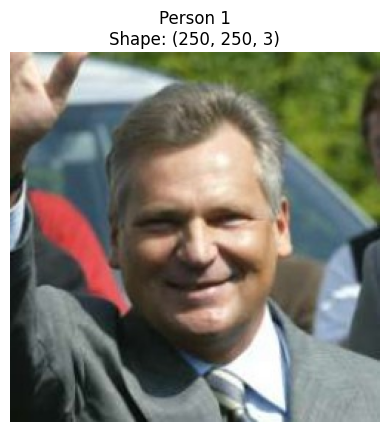

In [103]:
# plotting an image
image = dataset.imgs[5][0]
image = plt.imread(image)
plt.imshow(image)
plt.axis(False)
plt.title(f"Person 1\nShape: {image.shape}");

### 2.2. Preparing DataLoader

In [104]:
def collate_fn(x):
    return x[0]

dataloader = DataLoader(dataset, collate_fn=collate_fn)
dataloader

In [105]:
next(iter(dataloader))

(<PIL.Image.Image image mode=RGB size=1280x720>, 0)

## 3. Model Building

### 3.1. Model 1: MTCNN and InceptionResnetV1

In [107]:
mtcnn = MTCNN(image_size=240, margin=0, min_face_size=40)
resnet = InceptionResnetV1(pretrained='vggface2').eval()

In [108]:
idx_to_class

{0: 'Kathir', 1: 'Person 1', 2: 'Person 2', 3: 'Person 3', 4: 'Person 4'}

In [109]:
name_list = [] # list of corresponding names of cropped faces
embedding_list = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet

for img, idx in dataloader:
    face, prob = mtcnn(img, return_prob=True) 
    if face is not None and prob > 0.80:
        emb = resnet(face.unsqueeze(0)) 
        embedding_list.append(emb.detach()) 
        name_list.append(idx_to_class[idx]) 

### 3.2. Saving the embeddings and names

In [110]:
data = [embedding_list, name_list] 
torch.save(data, 'data.pt')

## 4. Performing Detections

### 4.1. Detection on Image

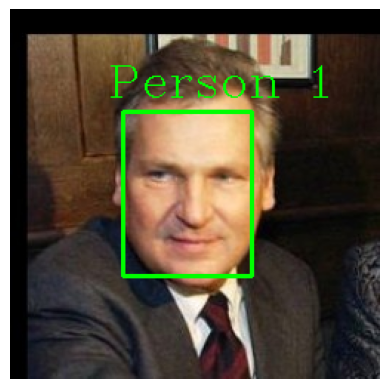

In [111]:
def face_match(img_path): 
    """
    Detects faces in an image and return the corresponding name.
    """
    img = cv2.imread(img_path)
    face, prob = mtcnn(img, return_prob=True) # returns cropped face and probability
    boxes, _ = mtcnn.detect(img)

    emb = resnet(face.unsqueeze(0)).detach()
    saved_data = torch.load('data.pt') # loading data.pt file
    embedding_list = saved_data[0] # getting embedding data
    name_list = saved_data[1] # getting list of names
    dist_list = [] # list of matched distances, minimum distance is used to identify the person

    for idx, emb_db in enumerate(embedding_list):
        dist = torch.dist(emb, emb_db).item()
        dist_list.append(dist)
        
    idx_min = dist_list.index(min(dist_list))

    if min(dist_list) < 0.80:
        name = name_list[idx_min]
    else:
        name = "Unknown"

    # Convert box coordinates to integers
    box = [int(coord) for coord in boxes[0]]

    # Draw text on the image
    frame = cv2.putText(img, f"{name}", (box[0] - 10, box[1] - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0))

    frame = cv2.rectangle(img, (box[0],box[1]) , (box[2],box[3]), (0,255,0), 2)

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis(False);
    

face_match("Test/Person 1/3.jpg")

### 4.2. Live Detection

In [112]:
from timeit import default_timer
def perform_live_detection():
    """
    Opens the camera and perform live detection.
    """
    # Opening camera
    cap = cv2.VideoCapture(0)

    while True:
        # Capture video frame
        ret, img = cap.read()
        start_time = default_timer()

        face, prob = mtcnn(img, return_prob=True) # returns cropped face and probability

        if face is not None:
            boxes, _ = mtcnn.detect(img)

            if prob > 0.80:
                emb = resnet(face.unsqueeze(0)).detach()

                saved_data = torch.load('data.pt') # loading data.pt file
                embedding_list = saved_data[0] # getting embedding data
                name_list = saved_data[1] # getting list of names
                dist_list = [] # list of matched distances, minimum distance is used to identify the person

                for idx, emb_db in enumerate(embedding_list):
                    dist = torch.dist(emb, emb_db).item()
                    dist_list.append(dist)
                    
                idx_min = dist_list.index(min(dist_list))

                if min(dist_list) < 1.0:
                    name = name_list[idx_min]
                else:
                    name = "Unknown"
                    # print("UNKNOWN PERSON ALERT !!!!")

                end_time = default_timer()
                # print(f"Time Taken: {end_time - start_time:.2f}s")

                # Convert box coordinates to integers
                box = [int(coord) for coord in boxes[0]]

                # Draw text on the image
                frame = cv2.putText(img, f"{name}", (box[0] - 10, box[1] - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0))

                frame = cv2.rectangle(img, (box[0],box[1]) , (box[2],box[3]), (0,255,0), 2)

        cv2.imshow("Live Detection", img)

        # Break the loop when 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()

In [113]:
# launch live detection
perform_live_detection()

### 5.1. Evaluating the model

In [56]:
test_path = "Test/"
test_imgs = []
for person in os.listdir(test_path):
    temp = test_path + person + "/"
    for img in os.listdir(temp):
        test_imgs.append([temp + img, person])
test_imgs

[['Test/Person 1/3.jpg', 'Person 1'],
 ['Test/Person 2/3.jpg', 'Person 2'],
 ['Test/Person 3/2.jpg', 'Person 3'],
 ['Test/Person 3/3.jpg', 'Person 3'],
 ['Test/Person 4/2.jpg', 'Person 4']]

In [57]:
from timeit import default_timer
import pandas as pd
def evaluate(test_img_path): 
    """
    Calculates Accuracy and Time Taken for detection.
    """
    start_time = default_timer()

    mtcnn = MTCNN(image_size=240, margin=0, min_face_size=40)
    resnet = InceptionResnetV1(pretrained='vggface2').eval()

    os.makedirs("detect", exist_ok=True)
    names = []

    for img_path, label in test_img_path:
        img = cv2.imread(img_path)
        face, prob = mtcnn(img, return_prob=True) # returns cropped face and probability

        emb = resnet(face.unsqueeze(0)).detach()

        saved_data = torch.load('data.pt') # loading data.pt file
        embedding_list = saved_data[0] # getting embedding data
        name_list = saved_data[1] # getting list of names
        dist_list = [] # list of matched distances, minimum distance is used to identify the person

        for emb_db in embedding_list:
            dist = torch.dist(emb, emb_db).item()
            dist_list.append(dist)
            
        idx_min = dist_list.index(min(dist_list))

        names.append([name_list[idx_min], label])
    
    end_time = default_timer()
    
    # Calculating accuracy
    acc_count = 0
    for pred, actual in names:
        if pred == actual:
            acc_count += 1

    # Calculating precision and recall
    tp = 0
    fp = 0
    fn = 0  # Corrected this line

    for pred, actual in names:
        if pred == actual:
            tp += 1
        else:
            fp += 1
            fn += 1  # Corrected this line

    # Calculate false negatives for recall
    # fn = Total Actual Positives - True Positives (already calculated above)

    # Calculate accuracy, precision, and recall
    accuracy = acc_count / len(names)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)


    return pd.DataFrame([accuracy, precision, recall, f"{end_time - start_time:.2f}s"], columns=["Model_1_MTCNN_Resnet"], index=["Accuracy", "Precision", "Recall", "Time Taken"]).T
    

model_1_results = evaluate(test_imgs)
model_1_results

,Accuracy,Precision,Recall,Time Taken
Model_1_MTCNN_Resnet,1.0,1.0,1.0,0.95s


## 6. Asking the user to add or perform detection

In [84]:
def train_model():
    """
    Trains the model with added data.
    """

    def collate_fn(x):
        """
        Used to format the dataloader.
        """
        return x[0]

    dataset = datasets.ImageFolder('Train') # Train folder path 
    dataloader = DataLoader(dataset, collate_fn=collate_fn)
    idx_to_class = {i:c for c,i in dataset.class_to_idx.items()}

    mtcnn = MTCNN(image_size=160, margin=0, min_face_size=40)
    resnet = InceptionResnetV1(pretrained='vggface2').eval()

    name_list = [] # list of corresponding names of cropped faces
    embedding_list = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet

    for img, idx in dataloader:
        face, prob = mtcnn(img, return_prob=True) 
        if face is not None and prob > 0.80:
            emb = resnet(face.unsqueeze(0)) 
            embedding_list.append(emb.detach()) 
            name_list.append(idx_to_class[idx])  

    data = [embedding_list, name_list]
    torch.save(data, 'data.pt')

In [85]:
import time
def capture_photo():
    """
    Captures the pictures of the employees.
    """
    print("Only 5 images per employee...\n")
    print("Enter Employee Name: ", end="")

    name = input()
    img_count = 0

    save_path = f"Train/{name}/"
    os.makedirs(save_path, exist_ok=True)

    instructions = ["Look Forward", "Look Left side", "Look Right side", "Look Upwards", "Look Downwards"]


    # Opening camera
    cap = cv2.VideoCapture(0)

    while (img_count < 5):
        
        print(f"Image {img_count + 1} will be taken in 3 seconds.\n")
        print(instructions[img_count] + "\n")

        time.sleep(3)

        # Capture video frame
        ret, img = cap.read()

        img_filename = f"{save_path}/{img_count + 1}.jpg"
        cv2.imwrite(img_filename, img)

        print(f"Image {img_count + 1} taken.\n")
        
        img_count += 1

    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()

In [86]:
from timeit import default_timer
def perform_live_detection():
    """
    Opens the camera and perform live detection.
    """
    mtcnn = MTCNN(image_size=240, margin=0, min_face_size=40)
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    
    # Opening camera
    cap = cv2.VideoCapture(0)

    print("Press q to quit Live Detection")

    while True:
        # Capture video frame
        ret, img = cap.read()
        
        start_time = default_timer()
        face, prob = mtcnn(img, return_prob=True) # returns cropped face and probability

        if face is not None:
            boxes, _ = mtcnn.detect(img)

            if prob > 0.80:
                emb = resnet(face.unsqueeze(0)).detach()

                saved_data = torch.load('data.pt') # loading data.pt file
                embedding_list = saved_data[0] # getting embedding data
                name_list = saved_data[1] # getting list of names
                dist_list = [] # list of matched distances, minimum distance is used to identify the person

                for emb_db in embedding_list:
                    dist = torch.dist(emb, emb_db).item()
                    dist_list.append(dist)
                    
                idx_min = dist_list.index(min(dist_list))

                if min(dist_list) < 0.70:
                    name = name_list[idx_min]
                else:
                    name = "Unknown"
                end_time = default_timer()
                # print(f"Time taken for detection: {end_time - start_time:.2f}s.")

                # Convert box coordinates to integers
                box = [int(coord) for coord in boxes[0]]

                # Draw text on the image
                frame = cv2.putText(img, f"{name}", (box[0] - 10, box[1] - 10), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 255, 0))

                frame = cv2.rectangle(img, (box[0],box[1]) , (box[2],box[3]), (0,255,0), 2)

        cv2.imshow("Live Detection", img)

        # Break the loop when 'q' key is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object and close all windows
    cap.release()
    cv2.destroyAllWindows()

In [88]:
import torch
from facenet_pytorch import MTCNN, InceptionResnetV1
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import cv2
import os
import time

user_input = 0

while user_input != 3:
    print("Face Recognition System\n")
    print("Choose an option to continue: \n"\
        "1. Add a new person\n"\
        "2. Perform live detection\n"\
        "3. Exit\n")

    time.sleep(2)

    user_input = int(input())

    if user_input == 1:
        capture_photo()
        train_model()

    elif user_input == 2:
        perform_live_detection()

Face Recognition System

Choose an option to continue: 
1. Add a new person
2. Perform live detection
3. Exit

Only 5 images per employee...

Enter Employee Name: Image 1 will be taken in 3 seconds.

Look Forward

Image 1 taken.

Image 2 will be taken in 3 seconds.

Look Left side

Image 2 taken.

Image 3 will be taken in 3 seconds.

Look Right side

Image 3 taken.

Image 4 will be taken in 3 seconds.

Look Upwards

Image 4 taken.

Image 5 will be taken in 3 seconds.

Look Downwards

Image 5 taken.

Face Recognition System

Choose an option to continue: 
1. Add a new person
2. Perform live detection
3. Exit

Press q to quit Live Detection
Face Recognition System

Choose an option to continue: 
1. Add a new person
2. Perform live detection
3. Exit

